In [21]:
# ipmrot libraries
import torch
from torch import nn
import numpy as np 
print(torch.__version__)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

1.13.0.dev20220907


In [1]:
# set up Spark
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.memory.offHeap.size","30g")\
    .appName("GenericAppName") \
    .getOrCreate()

print("APP Name :"+ spark.sparkContext.appName);
print("Master :"+ spark.sparkContext.master);

sqlContext = SQLContext(spark.sparkContext)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/15 07:21:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/15 07:21:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
APP Name :GenericAppName
Master :local[*]


/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
# read in data

data_train_path = 'emnist/emnist-balanced-train.csv'
data_test_path = 'emnist/emnist-balanced-test.csv'

df_train = spark.read.csv(data_train_path, header = False, inferSchema = True)
df_test = spark.read.csv(data_test_path, header = False, inferSchema = True)

In [3]:
import numpy as np

col_nums = np.linspace(0,783, 784, dtype='int')
feature_col_names = list(map(lambda n: 'col_'+str(n), col_nums))

all_cols_names = ['outcome'] + feature_col_names

df_train = df_train.toDF(*all_cols_names)
df_test = df_test.toDF(*all_cols_names)

In [4]:
# remove all lowercase letters to keep only digits and uppercase letters
df_train = df_train.where(df_train['outcome'] < 36)
df_test = df_test.where(df_test['outcome'] < 36)


In [5]:
# develop PySpark pipeline to vectorize features

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline, Transformer

class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df


def get_process_pipeline():
    stage_vector_assembler = VectorAssembler(inputCols=feature_col_names, outputCol="features")
    
    column_dropper = ColumnDropper(columns_to_drop = list(feature_col_names))
    
    pipeline = Pipeline(stages=[stage_vector_assembler, column_dropper])
    
    return pipeline

process_pipeline = get_process_pipeline()

In [6]:
# fit and transform training data
process_pipeline_fitted = process_pipeline.fit(df_train)
train_transform = process_pipeline_fitted.transform(df_train)

In [7]:
# transform testing data
test_transform = process_pipeline_fitted.transform(df_test)

In [8]:
# split testing data to get validation data
test_transform_validate, test_transform = test_transform.randomSplit([0.5, 0.5])

In [10]:
# create Torch Dataset
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset): 
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx],self.y[idx])
    

train = MyDataset(np.array(train_transform.toPandas()['features'].values.tolist()),
                  np.array(train_transform.toPandas()['outcome'].values.tolist()))

22/12/15 07:35:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
validate = MyDataset(np.array(test_transform_validate.toPandas()['features'].values.tolist()),
                  np.array(test_transform_validate.toPandas()['outcome'].values.tolist()))

In [18]:
# define multiclass nn
import torch
from torch import nn

class myNN(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(  
            nn.Linear(input_dim,410),
            nn.ReLU(),
            nn.Linear(410,410),
            nn.ReLU(),
            nn.Linear(410,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
mymodel = myNN(784,36) 

print(mymodel)

myNN(
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=410, bias=True)
    (1): ReLU()
    (2): Linear(in_features=410, out_features=410, bias=True)
    (3): ReLU()
    (4): Linear(in_features=410, out_features=36, bias=True)
  )
)


In [13]:
# load our own dataset
df_own = spark.read.csv('our_own_splits.csv', header = True, inferSchema = True)

In [14]:
df_own_transform = process_pipeline_fitted.transform(df_own)


In [15]:
own = MyDataset(np.array(test_transform.toPandas()['features'].values.tolist()),
                  np.array(test_transform.toPandas()['outcome'].values.tolist()))

In [19]:
# train
lr = 0.0001
batch_size = 20
num_epochs = 20


train_dataloader = DataLoader(train, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate, batch_size = batch_size, shuffle = False)
own_dataloader = DataLoader(own,batch_size = batch_size,shuffle = False)


# for accuracy calcuations
from sklearn import metrics

def training(mymodel, lr = lr, batch_size  = batch_size, num_epochs = num_epochs):
    
    optimizer = torch.optim.SGD(mymodel.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    hyperparameters = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs}
    
    train_batch_losses = []
    losses = []
    validation_losses = []
    
    own_losses = []
    accuracies = []
    
    validation_accuracies = []
    own_accuracies = []

    
    criterion = nn.CrossEntropyLoss()
    
    print('# Epochs: '+str(num_epochs))
    print('Batch Size: '+str(batch_size))
    print('Learning Rate: '+str(lr)+'\n\n')
    
    for n in range(num_epochs):
    
        batch_losses = []
        batch_accuracies = []
        for x_b, y_b in train_dataloader:

            pred = mymodel(x_b.float())

            loss = criterion(pred, y_b.long())
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            # append loss and accuracy
            batch_losses.append(loss.detach().numpy())
            batch_accuracies.append(metrics.accuracy_score(y_b, torch.argmax(pred,1)))            
            train_batch_losses.append(loss.detach().numpy())
            
        validate_batch_losses = []
        validate_batch_models = []
        validate_batch_accuracies = []
        for x_vb, y_vb in validate_dataloader:

            pred = mymodel(x_vb.float())
            validate_batch_models.append(pred)
            
            # calculate loss
            loss = criterion(pred, y_vb.long())


            # append loss and accuracy 
            validate_batch_losses.append(loss.detach().numpy())
            validate_batch_accuracies.append(metrics.accuracy_score(y_vb, torch.argmax(pred,1)))
            
        own_batch_losses = []
        own_batch_models = []
        own_batch_accuracies = []
        for x_ob, y_ob in own_dataloader:

            pred = mymodel(x_ob.float())
            own_batch_models.append(pred)
            
            # calculate loss
            loss = criterion(pred, y_ob.long())


            # append loss and accuracy 
            own_batch_losses.append(loss.detach().numpy())
            own_batch_accuracies.append(metrics.accuracy_score(y_ob, torch.argmax(pred,1)))       
        
        
        
        losses.append(np.mean(batch_losses))
        accuracies.append(np.mean(batch_accuracies))
        validation_losses.append(np.mean(validate_batch_losses))
        validation_accuracies.append(np.mean(validate_batch_accuracies))
        own_losses.append(np.mean(own_batch_losses))
        own_accuracies.append(np.mean(own_batch_accuracies))
        
        print('Epoch '+str(n+1)+':')
        print('Train Loss: '+str(np.mean(batch_losses)))
        print('Train Accuracy: '+str(np.mean(batch_accuracies)))
        print('\nValidation Loss: '+str(np.mean(validate_batch_losses)))
        print('Validation Accuracy: '+str(np.mean(validate_batch_accuracies))+'\n')
        print('\nOwn Loss: '+str(np.mean(own_batch_losses)))
        print('Own Accuracy: '+str(np.mean(own_batch_accuracies))+'\n')
        
        
        if validation_accuracies[-1] == np.max(validation_accuracies):
            print('This is the best model so far. Saving model.\n\n')
            torch.save(mymodel.state_dict(), 'current_best_model')
        
    return hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies

hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies = training(mymodel)

# Epochs: 20
Batch Size: 20
Learning Rate: 0.0001


Epoch 1:
Train Loss: 1.7031446
Train Accuracy: 0.6025

Validation Loss: 1.0514066
Validation Accuracy: 0.6937733499377334


Own Loss: 1.0417849
Own Accuracy: 0.7114544319600499

This is the best model so far. Saving model.


Epoch 2:
Train Loss: 0.8562804
Train Accuracy: 0.7479166666666667

Validation Loss: 0.8259865
Validation Accuracy: 0.7518555417185554


Own Loss: 0.8294623
Own Accuracy: 0.7555555555555555

This is the best model so far. Saving model.


Epoch 3:
Train Loss: 0.69817007
Train Accuracy: 0.7878240740740742

Validation Loss: 0.7321568
Validation Accuracy: 0.7725404732254048


Own Loss: 0.7344967
Own Accuracy: 0.7860330836454432

This is the best model so far. Saving model.


Epoch 4:
Train Loss: 0.60767144
Train Accuracy: 0.8109953703703704

Validation Loss: 0.6702291
Validation Accuracy: 0.792403486924035


Own Loss: 0.6794129
Own Accuracy: 0.8012016229712858

This is the best model so far. Saving model.


Epoch 5:
Tr

No handles with labels found to put in legend.


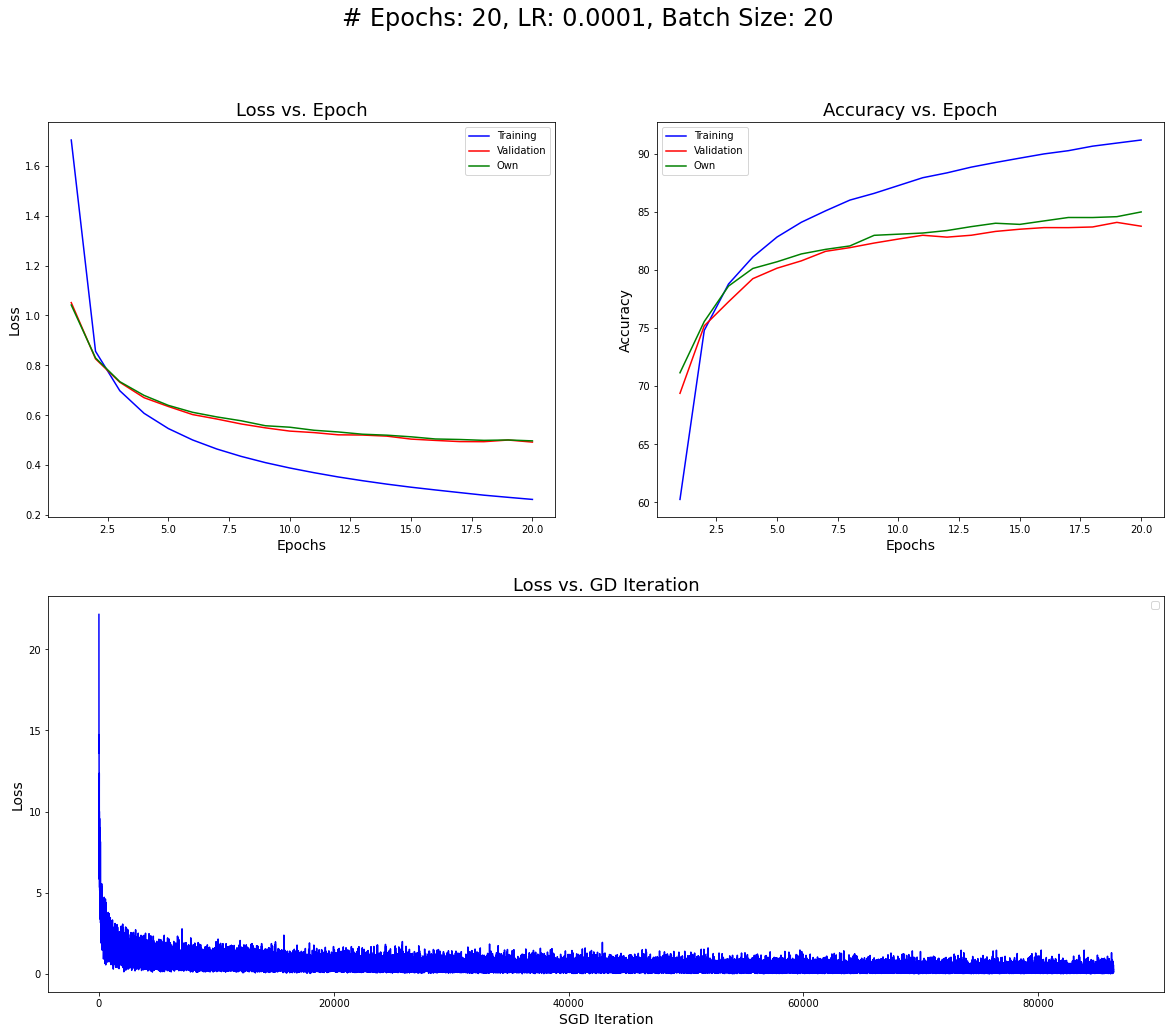

In [22]:
# plot
def plot_metrics(hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies):
    epochs = np.arange(1, len(losses) + 1)
    
    gs = gridspec.GridSpec(2,2)
    
    fig = plt.figure()
    fig.suptitle(f"# Epochs: {hyperparameters['num_epochs']}, LR: {hyperparameters['lr']}, Batch Size: {hyperparameters['batch_size']}"
                  , fontsize = 24)
    fig.set_size_inches(20, 16)
    
    # plot loss vs. epoch
    ax = plt.subplot(gs[0,0])
    plt.plot(epochs, losses, c = 'b', label = 'Training')
    plt.plot(epochs, validation_losses, c = 'r', label = 'Validation')
    plt.plot(epochs, own_losses, c = 'g', label = 'Own')
    plt.title('Loss vs. Epoch', fontsize=18)
    plt.xlabel('Epochs', fontsize =14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
    # plot accuracy vs. epoch
    ax = plt.subplot(gs[0,1])
    ax.plot(epochs, np.array(accuracies) * 100, c = 'b', label = 'Training')
    ax.plot(epochs, np.array(validation_accuracies) * 100, c = 'r', label = 'Validation')
    ax.plot(epochs, np.array(own_accuracies) * 100, c = 'g', label = 'Own')
    plt.title('Accuracy vs. Epoch', fontsize=18)
    plt.xlabel('Epochs', fontsize =14)
    plt.ylabel('Accuracy', fontsize = 14)
    plt.legend()
    
    # plot loss vs. sgd iteration
    ax = plt.subplot(gs[1,:])
    ax.plot(np.arange(1, len(train_batch_losses)+1), train_batch_losses, c = 'b')
    plt.title('Loss vs. GD Iteration', fontsize=18)
    plt.xlabel('SGD Iteration', fontsize =14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
    # save figure
    fig.savefig(f"Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')
    
    
plot_metrics(hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies)

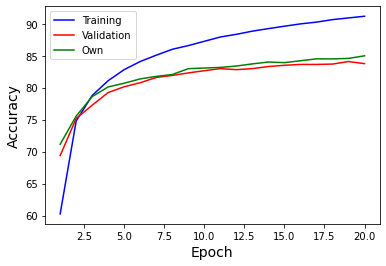

In [49]:
lr = 0.0001
batch_size = 20
num_epochs = 20

hyperparameters = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs}

epochs = np.arange(1, len(losses) + 1)
plt.plot(epochs, np.array(accuracies) * 100, c = 'b', label = 'Training')
plt.plot(epochs, np.array(validation_accuracies) * 100, c = 'r', label = 'Validation')
plt.plot(epochs, np.array(own_accuracies) * 100, c = 'g', label = 'Own')
plt.xlabel('Epoch', fontsize =14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()
plt.savefig(f"Accuracy Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')

In [24]:
# print final accuracies
print('Train Accuracy: '+str(accuracies[-1]))
print('Validate Accuracy: '+str(validation_accuracies[-1]) + ' (using Test Set)')
print('Own Accuracy: '+str(own_accuracies[-1]))

Train Accuracy: 0.911712962962963
Validate Accuracy: 0.8375591531755916 (using Test Set)
Own Accuracy: 0.8498283395755306


In [25]:
# load best model and evaluate on test dataset
batch_size = 20

mybestmodel = myNN(784,36)
mybestmodel.load_state_dict(torch.load('current_best_model'))

own_accuracies_test = []

for x_b, y_b in own_dataloader:
    pred = mybestmodel(x_b.float())
    own_accuracies_test.append(metrics.accuracy_score(y_b, torch.argmax(pred,1)))
    
print('Test Accuracy: '+str(np.mean(own_accuracies_test)))

Test Accuracy: 0.8457553058676655


# Tuning

## Dropout

In [26]:
# defining dropout nn
from torch import nn

class myNN_dropout(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(  
            nn.Linear(input_dim,410),
            nn.ReLU(),
            nn.Linear(410,410),
            nn.Dropout(0.20),
            nn.ReLU(),
            nn.Linear(410,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
dropout_model = myNN_dropout(784,36) 

print(dropout_model)

myNN_dropout(
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=410, bias=True)
    (1): ReLU()
    (2): Linear(in_features=410, out_features=410, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=410, out_features=36, bias=True)
  )
)


In [27]:
# train with dropout
dropo_hyperparameters, dropo_losses, dropo_train_batch_losses, dropo_validation_losses, dropo_accuracies, dropo_validation_accuracies, dropo_own_losses, dropo_own_accuracies = training(dropout_model)

# Epochs: 20
Batch Size: 20
Learning Rate: 0.0001


Epoch 1:
Train Loss: 2.1106067
Train Accuracy: 0.5123263888888889

Validation Loss: 1.2856892
Validation Accuracy: 0.6370859277708594


Own Loss: 1.2995499
Own Accuracy: 0.6334425717852685

This is the best model so far. Saving model.


Epoch 2:
Train Loss: 1.0719914
Train Accuracy: 0.6861226851851853

Validation Loss: 1.0299731
Validation Accuracy: 0.7005354919053549


Own Loss: 1.0296493
Own Accuracy: 0.7001560549313358

This is the best model so far. Saving model.


Epoch 3:
Train Loss: 0.8822879
Train Accuracy: 0.7311226851851852

Validation Loss: 0.8833932
Validation Accuracy: 0.733200498132005


Own Loss: 0.8989303
Own Accuracy: 0.7327715355805243

This is the best model so far. Saving model.


Epoch 4:
Train Loss: 0.7756674
Train Accuracy: 0.7602314814814815

Validation Loss: 0.8202768
Validation Accuracy: 0.7485678704856787


Own Loss: 0.82778186
Own Accuracy: 0.7520131086142323

This is the best model so far. Saving model.




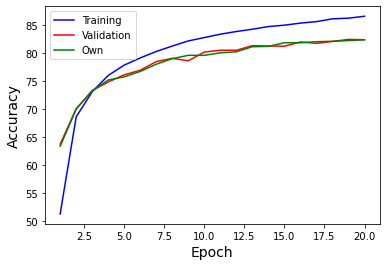

In [50]:
lr = 0.0001
batch_size = 20
num_epochs = 20

hyperparameters = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs}

epochs = np.arange(1, len(dropo_losses) + 1)
plt.plot(epochs, np.array(dropo_accuracies) * 100, c = 'b', label = 'Training')
plt.plot(epochs, np.array(dropo_validation_accuracies) * 100, c = 'r', label = 'Validation')
plt.plot(epochs, np.array(dropo_own_accuracies) * 100, c = 'g', label = 'Own')
plt.xlabel('Epoch', fontsize =14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()
plt.savefig(f"Dropout Accuracy Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')

No handles with labels found to put in legend.


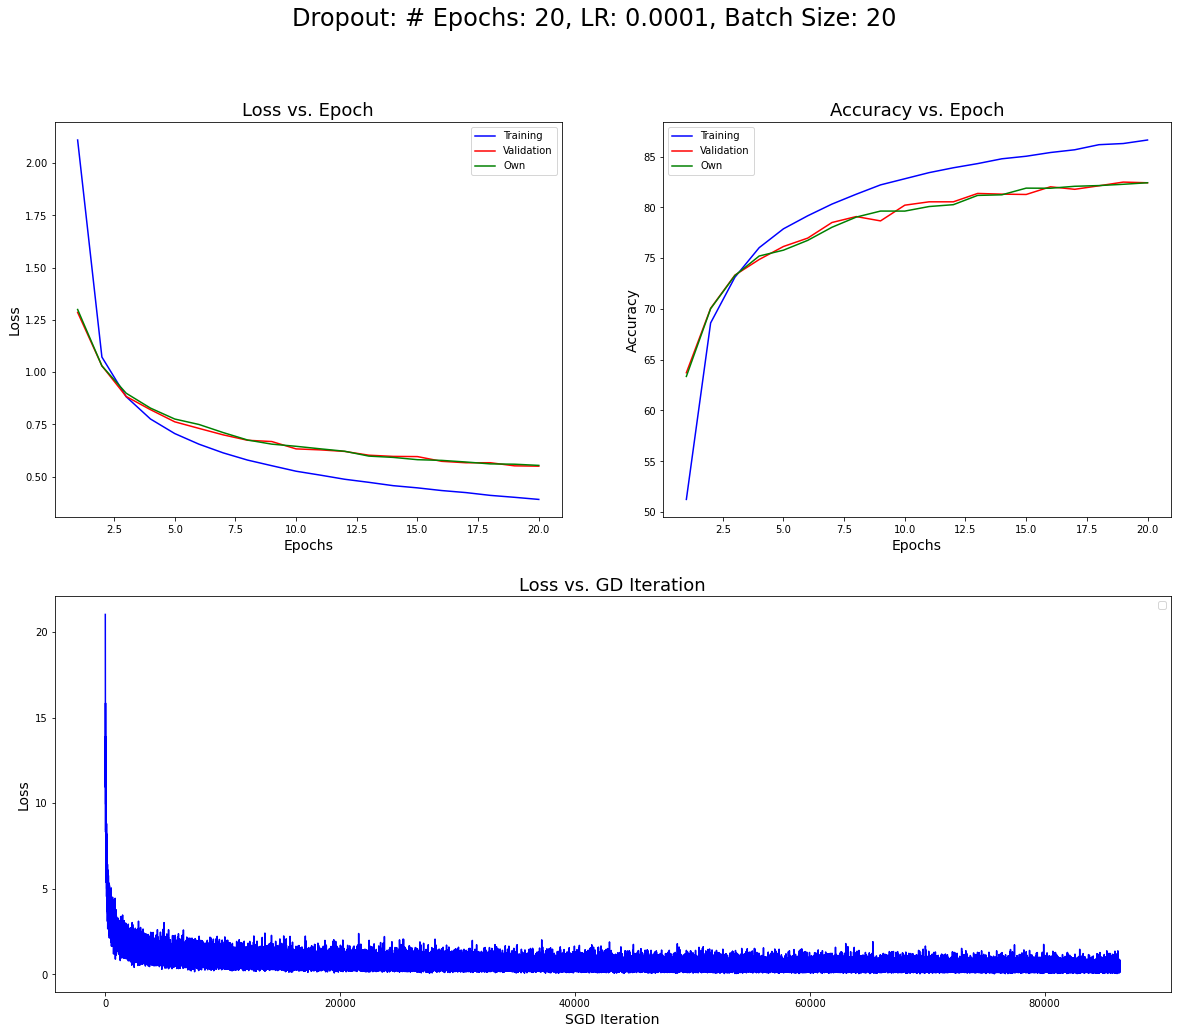

In [29]:
# plot dropout
def plot_metrics_dropout(hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies):
    epochs = np.arange(1, len(losses) + 1)
    
    gs = gridspec.GridSpec(2,2)
    
    fig = plt.figure()
    fig.suptitle(f"Dropout: # Epochs: {hyperparameters['num_epochs']}, LR: {hyperparameters['lr']}, Batch Size: {hyperparameters['batch_size']}"
                  , fontsize = 24)
    fig.set_size_inches(20, 16)
    
    # plot loss vs. epoch
    ax = plt.subplot(gs[0,0])
    plt.plot(epochs, losses, c = 'b', label = 'Training')
    plt.plot(epochs, validation_losses, c = 'r', label = 'Validation')
    plt.plot(epochs, own_losses, c = 'g', label = 'Own')
    plt.title('Loss vs. Epoch', fontsize=18)
    plt.xlabel('Epochs', fontsize =14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
    # plot accuracy vs. epoch
    ax = plt.subplot(gs[0,1])
    ax.plot(epochs, np.array(accuracies) * 100, c = 'b', label = 'Training')
    ax.plot(epochs, np.array(validation_accuracies) * 100, c = 'r', label = 'Validation')
    ax.plot(epochs, np.array(own_accuracies) * 100, c = 'g', label = 'Own')
    plt.title('Accuracy vs. Epoch', fontsize=18)
    plt.xlabel('Epochs', fontsize =14)
    plt.ylabel('Accuracy', fontsize = 14)
    plt.legend()
    
    # plot loss vs. sgd iteration
    ax = plt.subplot(gs[1,:])
    ax.plot(np.arange(1, len(train_batch_losses)+1), train_batch_losses, c = 'b')
    plt.title('Loss vs. GD Iteration', fontsize=18)
    plt.xlabel('SGD Iteration', fontsize =14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
    # save figure
    fig.savefig(f"Dropout Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')
    
    
plot_metrics_dropout(dropo_hyperparameters, dropo_losses, dropo_train_batch_losses, dropo_validation_losses, dropo_accuracies, dropo_validation_accuracies, dropo_own_losses, dropo_own_accuracies)

In [44]:
# print dropout final accuracies
print('Dropout')
print('Train Accuracy: '+str(dropo_accuracies[-1]))
print('Validate Accuracy: '+str(dropo_validation_accuracies[-1]) + ' (using Test Set)')
print('Own Accuracy: '+str(dropo_own_accuracies[-1]))

Dropout
Train Accuracy: 0.8662615740740741
Validate Accuracy: 0.824159402241594 (using Test Set)
Own Accuracy: 0.8241729088639201


## Hyperparameter Tuning

In [31]:
# tune
lr_arr = [0.001, 0.0015, 0.003]
batch_size_arr = [50, 100, 200]

hp_accuracies = []

for lr in lr_arr:
    for batch_size in batch_size_arr:

        run_name = 'Learning Rate: '+str(lr)+' Batch Size: '+str(batch_size)
        print('')
        #print('---Current Run: '+run_name+'---')
        print('------')
        hpt_hyperparameters, hpt_losses, hpt_train_batch_losses, hpt_validation_losses,hpt_accuracies, hpt_validation_accuracies, hpt_own_losses, hpt_own_accuracies = training(mymodel, lr = lr,
                                                                                batch_size = batch_size)
        
        hp_accuracies.append(hpt_own_accuracies[-1])
        
        if np.max(hp_accuracies) == hpt_own_accuracies[-1]:
            torch.save(mymodel.state_dict(), 'current_best_model_hpt')
            best_run_name = run_name
            print('New Best Model:', best_run_name)




------
# Epochs: 20
Batch Size: 50
Learning Rate: 0.001


Epoch 1:
Train Loss: 0.46415234
Train Accuracy: 0.8431944444444445

Validation Loss: 0.5621766
Validation Accuracy: 0.820323785803238


Own Loss: 0.55854714
Own Accuracy: 0.8267946317103619

This is the best model so far. Saving model.


Epoch 2:
Train Loss: 0.35762703
Train Accuracy: 0.8731134259259259

Validation Loss: 0.4970505
Validation Accuracy: 0.83920298879203


Own Loss: 0.51878893
Own Accuracy: 0.8398564294631712

This is the best model so far. Saving model.


Epoch 3:
Train Loss: 0.2998203
Train Accuracy: 0.8906018518518519

Validation Loss: 0.48277655
Validation Accuracy: 0.8460772104607721


Own Loss: 0.4890932
Own Accuracy: 0.8484238451935081

This is the best model so far. Saving model.


Epoch 4:
Train Loss: 0.25936902
Train Accuracy: 0.9021527777777778

Validation Loss: 0.48085895
Validation Accuracy: 0.8521917808219177


Own Loss: 0.47957465
Own Accuracy: 0.8524968789013733

This is the best model so far. Savi

In [51]:
# evaluate with best model
mybestmodel_hp = myNN(784,36)
mybestmodel_hp.load_state_dict(torch.load('current_best_model_hpt'))

own_accuracies_hpt = []

for x_b, y_b in own_dataloader:
    pred = mybestmodel_hp(x_b.float())
    own_accuracies_hpt.append(metrics.accuracy_score(y_b, torch.argmax(pred,1)))

print('Best Model: '+str(best_run_name))
print('Test Accuracy: '+str(np.mean(own_accuracies_hpt)))

Best Model: Learning Rate: 0.0015 Batch Size: 50
Test Accuracy: 0.8714887640449438


In [52]:
# print all tuning accuracies
i = 0
for lr in lr_arr:
    for batch_size in batch_size_arr:
        print('Learning Rate: '+str(lr)+' & Batch Size: '+str(batch_size)+': '+str(hp_accuracies[i]))
        i += 1
    print('\n')

Learning Rate: 0.001 & Batch Size: 50: 0.8686797752808989
Learning Rate: 0.001 & Batch Size: 100: 0.867556179775281
Learning Rate: 0.001 & Batch Size: 200: 0.864747191011236


Learning Rate: 0.0015 & Batch Size: 50: 0.8714887640449438
Learning Rate: 0.0015 & Batch Size: 100: 0.8665730337078652
Learning Rate: 0.0015 & Batch Size: 200: 0.861485642946317


Learning Rate: 0.003 & Batch Size: 50: 0.8469569288389512
Learning Rate: 0.003 & Batch Size: 100: 0.8453027465667916
Learning Rate: 0.003 & Batch Size: 200: 0.8373283395755307




## NN Model Tuning

In [34]:
# two hidden layers
class myNN_twohl(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(  
            nn.Linear(input_dim,410),
            nn.ReLU(),
            nn.Linear(410,410),
            nn.ReLU(),
            nn.Linear(410,410),
            nn.ReLU(),
            nn.Linear(410,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
mymodel_2hl = myNN_twohl(784,36) 

print(mymodel_2hl)

myNN_twohl(
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=410, bias=True)
    (1): ReLU()
    (2): Linear(in_features=410, out_features=410, bias=True)
    (3): ReLU()
    (4): Linear(in_features=410, out_features=410, bias=True)
    (5): ReLU()
    (6): Linear(in_features=410, out_features=36, bias=True)
  )
)


In [36]:
twohl_hyperparameters, twohl_losses, twohl_train_batch_losses, twohl_validation_losses, twohl_accuracies, twohl_validation_accuracies, twohl_own_losses, twohl_own_accuracies = training(mymodel = mymodel_2hl, lr = 0.0015, batch_size = 50)

# Epochs: 20
Batch Size: 50
Learning Rate: 0.0015


Epoch 1:
Train Loss: 0.75665665
Train Accuracy: 0.7656828703703704

Validation Loss: 0.5809034
Validation Accuracy: 0.812079701120797


Own Loss: 0.5688625
Own Accuracy: 0.8098002496878901

This is the best model so far. Saving model.


Epoch 2:
Train Loss: 0.44603434
Train Accuracy: 0.8494097222222222

Validation Loss: 0.4921927
Validation Accuracy: 0.8344333748443338


Own Loss: 0.48412547
Own Accuracy: 0.8383895131086143

This is the best model so far. Saving model.


Epoch 3:
Train Loss: 0.35404187
Train Accuracy: 0.8744444444444446

Validation Loss: 0.43617687
Validation Accuracy: 0.8586799501867994


Own Loss: 0.41195965
Own Accuracy: 0.8598002496878902

This is the best model so far. Saving model.


Epoch 4:
Train Loss: 0.29640898
Train Accuracy: 0.891724537037037

Validation Loss: 0.42173404
Validation Accuracy: 0.8604109589041096


Own Loss: 0.4064524
Own Accuracy: 0.8626092384519352

This is the best model so far. Saving mod

In [37]:
# print 2 hidden layers final accuracies
print('2 Hidden Layers')
print('Train Accuracy: '+str(twohl_accuracies[-1]))
print('Validate Accuracy: '+str(twohl_validation_accuracies[-1]) + ' (using Test Set)')
print('Own Accuracy: '+str(twohl_own_accuracies[-1]))

2 Hidden Layers
Train Accuracy: 0.9664814814814816
Validate Accuracy: 0.8782191780821919 (using Test Set)
Own Accuracy: 0.880727215980025


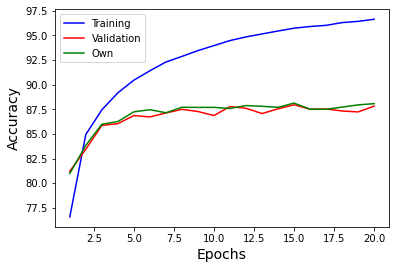

In [38]:
epochs = np.arange(1, len(twohl_losses) + 1)
plt.plot(epochs, np.array(twohl_accuracies) * 100, c = 'b', label = 'Training')
plt.plot(epochs, np.array(twohl_validation_accuracies) * 100, c = 'r', label = 'Validation')
plt.plot(epochs, np.array(twohl_own_accuracies) * 100, c = 'g', label = 'Own')
plt.xlabel('Epoch', fontsize =14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()
plt.savefig(f"2HL Accuracy Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')

In [40]:
# 2 hidden layers & 600 neurons
class myNN_width(nn.Module):
    def __init__(self,input_dim,output_dim, width):
        super().__init__()
        self.sequential = nn.Sequential(  
            nn.Linear(input_dim,width),
            nn.ReLU(),
            nn.Linear(width,width),
            nn.ReLU(),
            nn.Linear(width,width),
            nn.ReLU(),
            nn.Linear(width,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
mymodel_width = myNN_width(784, 36, 600) 

print(mymodel_width)

myNN_width(
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=600, bias=True)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=600, bias=True)
    (5): ReLU()
    (6): Linear(in_features=600, out_features=36, bias=True)
  )
)


In [42]:
width_hyperparameters, width_losses, width_train_batch_losses, width_validation_losses, width_accuracies, width_validation_accuracies, width_own_losses, width_own_accuracies = training(mymodel = mymodel_width, lr = 0.0015, batch_size = 50)

# Epochs: 20
Batch Size: 50
Learning Rate: 0.0015


Epoch 1:
Train Loss: 0.78709084
Train Accuracy: 0.7570601851851851

Validation Loss: 0.5145395
Validation Accuracy: 0.8314196762141969


Own Loss: 0.5149915
Own Accuracy: 0.8343789013732834

This is the best model so far. Saving model.


Epoch 2:
Train Loss: 0.41754118
Train Accuracy: 0.8573032407407408

Validation Loss: 0.4693916
Validation Accuracy: 0.8419676214196762


Own Loss: 0.46836972
Own Accuracy: 0.8454744069912609

This is the best model so far. Saving model.


Epoch 3:
Train Loss: 0.32269236
Train Accuracy: 0.8846875000000001

Validation Loss: 0.42380705
Validation Accuracy: 0.8555043586550436


Own Loss: 0.4181263
Own Accuracy: 0.8607833957553058

This is the best model so far. Saving model.


Epoch 4:
Train Loss: 0.26302335
Train Accuracy: 0.9030324074074075

Validation Loss: 0.41326395
Validation Accuracy: 0.8585180572851806


Own Loss: 0.4210374
Own Accuracy: 0.8641541822721599

This is the best model so far. Saving mo

In [53]:
# print 2 hidden layers, 600 neurons, final accuracies
print('2 Hidden Layers, 600 neurons')
print('Train Accuracy: '+str(width_accuracies[-1]))
print('Validate Accuracy: '+str(width_validation_accuracies[-1]) + ' (using Test Set)')
print('Own Accuracy: '+str(width_own_accuracies[-1]))

2 Hidden Layers, 600 neurons
Train Accuracy: 0.9730902777777778
Validate Accuracy: 0.8759153175591533 (using Test Set)
Own Accuracy: 0.8766541822721599
